# Parser for HWDDDA Project

In [1]:
#! pip install pandas
#! pip install matplotlib
#! pip install vectormath
#! pip install pyvista
#! pip install vtk

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vectormath as vmath
import pyvista as pv
from datetime import datetime, timedelta

import panel
panel.extension("vtk")
pv.set_plot_theme("document")

skiprows = 0 #used for ProcessData() to slide the start of the window

## LoadData() - read csv file and load it to a dataframe

Read the datafile and stick it in a data frame. Fixup a bunch of the data in the process (i.e. parse dates, calculate time per sample to interpolate the repeated timestamp blocks)

The data file starts with a calibration block (not currently parsing that calibration, just skipping it).

Since we have a bunch of data files, wrap this parsing into a function so we can cleanly call it once for each file.

Use either the stoprow or the rowcount. Stoprow takes precedence. This is meant to limit the loaded data, but still provide a workable dataset that can be diced up later and re-processed without reloading the whole file.

In [3]:
def LoadData(fname, startrow=0, stoprow=999999999999, rowcount=-1):
    filename = "../../data/preliminary/" + fname
    def f(s): #need to left pad the milliseconds
        if(len(s) != 21): #the string length (should) only vary by the last 3 characters, i.e. ms
            s = s[0:s.rfind(":")] + ":" + s[s.rfind(":")+1:].zfill(3)
        return pd.to_datetime(s, format="%m/%d/%y-%H:%M:%S:%f", errors="ignore")

    
    if rowcount > 0: #update the stoprow if we were passed a valid rowcount
        stoprow = startrow + rowcount
    
    
    #TODO: need to use readable column names to avoid confusion
    #pressure, temperature, voltage, accel1, accel2, accel3, strain gauge1, strain gauge2, strain gauge3
    headers = ["dt", "Sch", "Press", "Temp", "Volt", "AccX", "AccY", "AccZ", "Str1", "Str2", "Str3"]
    #headers = ["dt", "Sch", "Ch0", "Ch1", "Ch2", "Ch3", "Ch4", "Ch5", "Ch6", "Ch7", "Ch8"]#, "empty"]
    df = pd.read_csv(filename, 
                     header=None, names=headers, 
                     index_col=False, #deal with trailing comma shifting the columns
                     skiprows=12+startrow,  #skip the calibration block for now
                     nrows=stoprow-startrow,
                     parse_dates=["dt"],
                     date_parser=f,
                     low_memory=False)
    
    
    #add a counter column for easy plotting. Keep the index so we can narrow the plots (i.e. use the x value to remap this function's start/stop row).
    df.insert(loc=0, column="cnt", value=np.arange(start=startrow, stop=len(df)+startrow))
    
    #add a column for the millisecond of the given sample
    #NOTE: this is not backwards validated... just the time from beginning to the end
    #TODO: this is slightly flawed in that the arbitrary start/stop daetime isnt the actual timestamp of that specific record (need to back up to the first of the repeated timestamp value)
    #TODO: better interpolation is done in the block below... should use that to get totalms (see column totalmsalt)
    #TODO: probably ditch this calc in favor of totalmsalt below.
    totalms = (df["dt"][len(df)-1] - df["dt"][0]).total_seconds() * 1000
    if np.isnan(totalms):
        print("ERROR: couldnt determine total milliseconds. Check input file.")
    else:
        mspersample = totalms / len(df)
        #print(mspersample)
        df.insert(loc=1, column="totalms", value=np.arange(start=0, stop=totalms, step=mspersample))
    
    
    #iterate to fixup the time per sample calculated. This is sloppy and slow, but should be functional enough
    #this calculates the time per sample and interpolates the wallclock timestamp for the repeated timestamps in a block
    mspersample = []
    fixedts = []
    basets = np.nan #holds the base timestamp, i.e. the first timestamp in a block
    nextts = np.nan #holds the next timestamp, i.e. the value of the next block
    countts = 0 #holds the number of repeated timestamps for the current block
    countcurr = 0
    for index, row in df.iterrows():
        #print(index, "-------")
        if basets != row["dt"]: #the current timestamp changed, so we need to update a bunch of things for this block
            basets = row["dt"] #update the current block's NEW timestamp
            countts = 0
            countcurr = 0
            #find the next timestamp and count the values
            for x in range(20): #limit to 20 to find the next new timestamp, just to bound the search
                dfindex = index + x
                if dfindex >= len(df): break #fell off the end
                
                if basets == df["dt"][dfindex]: #found a repeat
                    countts += 1 #count the repeated values (could also set to x)
                else: #found a new timestamp, so we're done
                    nextts = df["dt"][dfindex]
                    break
        else: #current timestamp didnt change, so just use the previously calculated values
            countcurr += 1
        msval = ((nextts - basets).total_seconds() * 1000) / countts
        mspersample.append(msval)
        fixedts.append(basets + timedelta(microseconds=(msval * 1000 * countcurr)))
        
    #this is probably a more accurate reading of the totalms compared to the method above
    df.insert(loc=2, column="totalmsalt", value=np.cumsum(mspersample)-mspersample[0]) #hack to shift all the values back to start at zero
    
    df.insert(loc=3, column="mspersample", value=mspersample)
    df.insert(loc=4, column="fixedts", value=fixedts)
    
    
    print("# of rows:", len(df))
    #print(df)
    #print(df.head(5))
    
    return(df)

## ProcessData() - Process the previously loaded dataframe into a new dataframe

Adds the following columns to a new dataframe (so we can reprocess the original without loading it back from disk): 

AccelCalibG[x/y/z]    AccelZeroedG[x/y/z]   Vel[x/y/z]

PosDelta[x/y/z] the change in position

Pos[x/y/z] the total position

In [4]:
def ProcessData(tmpdf, calib, skiprows=0, rowcount=99999999):
    print("skipping rows:", skiprows)
    dfcalib = df[skiprows:skiprows+rowcount].copy() #because we are going to dice up the dataframe, and we will likely want to re-process it
    
    #calibrate the values
    dfcalib["AccelCalibGX"] =  (df["AccX"] - calib["AccelZeroX"]) / calib["AccelGainX"]
    dfcalib["AccelCalibGY"] =  (df["AccY"] - calib["AccelZeroY"]) / calib["AccelGainY"]
    dfcalib["AccelCalibGZ"] =  (df["AccZ"] - calib["AccelZeroZ"]) / calib["AccelGainZ"]
    
    
    #Get the average over a larger swath (i.e. the full dataset loaded into df).
    calib["AccelMeanX"] = (df["AccX"].mean() - calib["AccelZeroX"]) / calib["AccelGainX"]
    calib["AccelMeanY"] = (df["AccY"].mean() - calib["AccelZeroY"]) / calib["AccelGainY"]
    calib["AccelMeanZ"] = (df["AccZ"].mean() - calib["AccelZeroZ"]) / calib["AccelGainZ"]
    
    
    
    #subtract off the mean to give zeroed calibrated G's with gravity removed
    dfcalib["AccelZeroedGX"] = dfcalib["AccelCalibGX"] - calib["AccelMeanX"]
    dfcalib["AccelZeroedGY"] = dfcalib["AccelCalibGY"] - calib["AccelMeanY"]
    dfcalib["AccelZeroedGZ"] = dfcalib["AccelCalibGZ"] - calib["AccelMeanZ"]
    
    #TODO: use the milliseconds per sample to calculate the actual velocity
    
    dfcalib["VelX"] = ((dfcalib["AccelZeroedGX"]+dfcalib["AccelZeroedGX"].shift(1))/2 * (dfcalib["mspersample"] / 1000) * 386.0886).cumsum()
    dfcalib["VelY"] = ((dfcalib["AccelZeroedGY"]+dfcalib["AccelZeroedGY"].shift(1))/2 * (dfcalib["mspersample"] / 1000) * 386.0886).cumsum()
    dfcalib["VelZ"] = ((dfcalib["AccelZeroedGZ"]+dfcalib["AccelZeroedGZ"].shift(1))/2 * (dfcalib["mspersample"] / 1000) * 386.0886).cumsum()

    dfcalib["PosDeltaX"] = dfcalib["VelX"] * dfcalib["mspersample"] / 1000
    dfcalib["PosDeltaY"] = dfcalib["VelY"] * dfcalib["mspersample"] / 1000
    dfcalib["PosDeltaZ"] = dfcalib["VelZ"] * dfcalib["mspersample"] / 1000
    dfcalib["PosX"] = dfcalib["PosDeltaX"].cumsum()
    dfcalib["PosY"] = dfcalib["PosDeltaY"].cumsum()
    dfcalib["PosZ"] = dfcalib["PosDeltaZ"].cumsum()
    
    return(dfcalib)

## PlotDataXXX() - Wrapper for some basic plotting.

In [5]:
def PlotDataRaw(_df):
    _df.plot(kind="scatter", x="cnt", y="AccelZeroedGZ", title="Acc Z", color="green")
    plt.show()
    _df.plot(kind="scatter", x="cnt", y="AccelZeroedGX", title="Acc X", color="red")
    plt.show()
    _df.plot(kind="scatter", x="cnt", y="AccelZeroedGY", title="Acc Y", color="blue")
    plt.show()

In [6]:
def PlotDataProcessed(_df, plotAll):
    if(plotAll == True):
        _df.plot(kind="scatter", x="cnt", y="VelZ", title="Velocity Z", color="green")
        plt.axhline(y=0, color="gray", linestyle="-")
        plt.show()
    _df.plot(kind="scatter", x="cnt", y="PosZ", title="Position Z", color="green")
    plt.axhline(y=0, color="gray", linestyle="-")
    plt.show()
    
    if(plotAll == True):
        _df.plot(kind="scatter", x="cnt", y="VelX", title="Velocity X", color="red")
        plt.axhline(y=0, color="gray", linestyle="-")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="PosX", title="Position X", color="red")
        plt.axhline(y=0, color="gray", linestyle="-")
        plt.show()    
    
        _df.plot(kind="scatter", x="cnt", y="VelY", title="Velocity Y", color="blue")
        plt.axhline(y=0, color="gray", linestyle="-")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="PosY", title="Position Y", color="blue")
        plt.axhline(y=0, color="gray", linestyle="-")
        plt.show()

## Actually load some data

Load data from the file. Only run one of these, or just make sure the last one is the one you want to use.

Try and get the start/stop row index to cover legitimate data (i.e. exclude bad startup and shutdown data if present).

We load the data here and then process it later so that we can operate on a subset of that data.

In [7]:
#df = LoadData("file_43_calibrated_20180516102829.csv") #this one has a bunch of empty values

In [8]:
df = LoadData("File_18_1002_Calibrated_20190510135452.csv", 0, 100)

# of rows: 100


In [9]:
df = LoadData("Thorman B-3/File_35_1002_Calibrated_20190801103404.csv", 8723, rowcount=5000)
#print(df)

calibration = {
    "AccelZeroX": 17288.88, #I'm not sure these are correct... See Lynn & Gabriel discussion.
    "AccelZeroY": 17217.23,
    "AccelZeroZ": 16897.29,
    
    "AccelGainX": 7314.35, 
    "AccelGainY": 7467.77, 
    "AccelGainZ": 7488.96,
    
    "AccelMeanX": np.nan, #update these in ProcessData()
    "AccelMeanY": np.nan,
    "AccelMeanZ": np.nan,
}

# of rows: 5000


## Visually find the optimal start sample

Use this to plot a bunch of calcs from varying starting samples. You can then quickly scan the plots to find the one where the position returns to zero.

All the position plots start at zero on the left (because that is our "assumed" boundry condition), but in reality the mechanical system is not actually at zero. The plot that returns to zero at the right is "likely" to have picked the correct starting sample where the mechanical system was actually at zero.

Once you find a good starting row number, you can use the next cell to further narrow it down.

<span style="color:blue"><b>Key point:</b> Find the plot that crosses the zero line on the right side</span>.

Processing a window of 600 samples, sliding at incriments of 10
skipping rows: 0


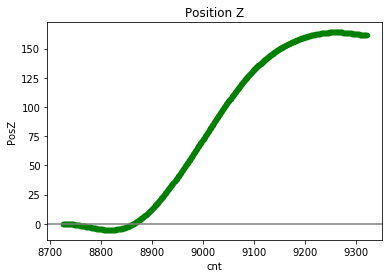

skipping rows: 10


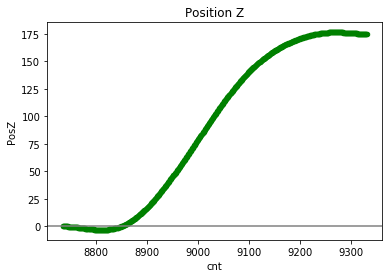

skipping rows: 20


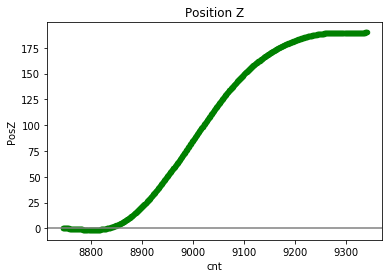

skipping rows: 30


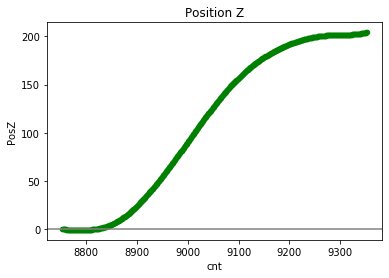

skipping rows: 40


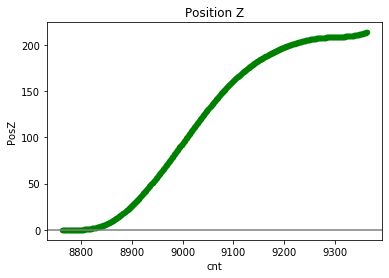

skipping rows: 50


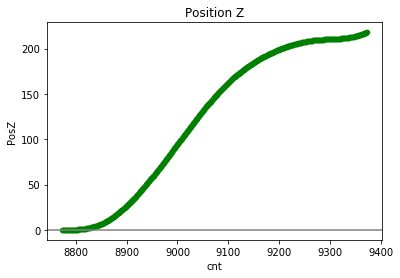

skipping rows: 60


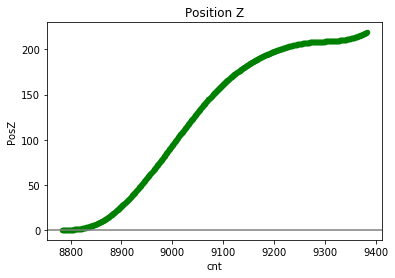

skipping rows: 70


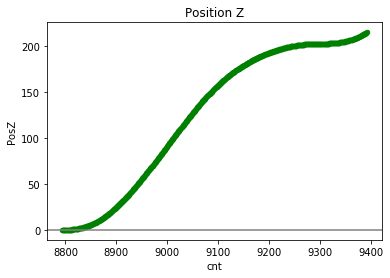

skipping rows: 80


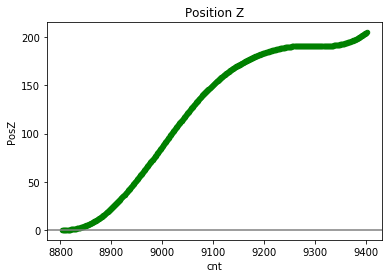

skipping rows: 90


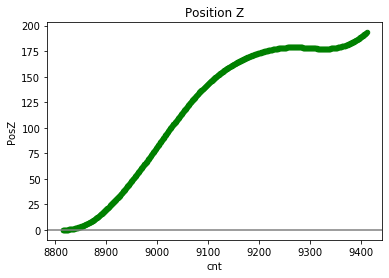

skipping rows: 100


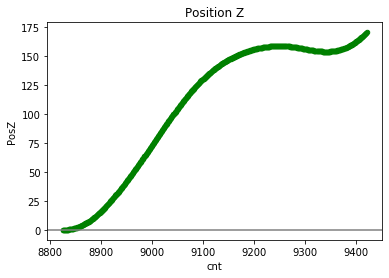

skipping rows: 110


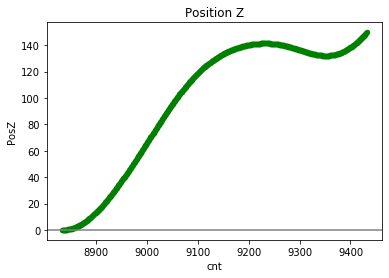

skipping rows: 120


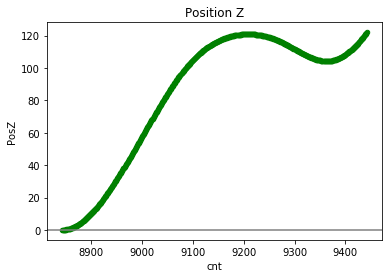

skipping rows: 130


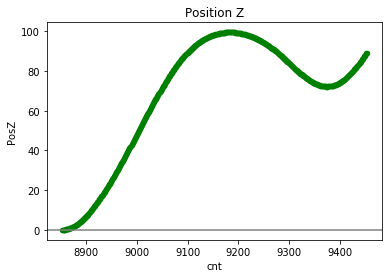

skipping rows: 140


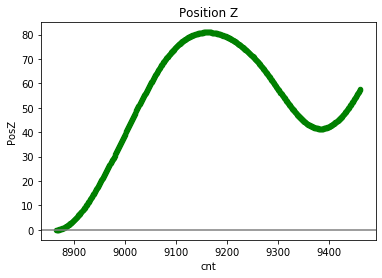

skipping rows: 150


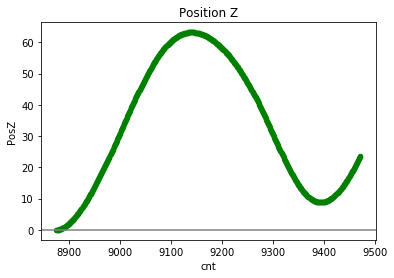

skipping rows: 160


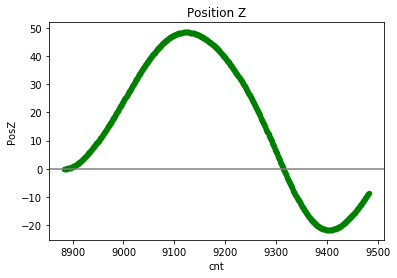

skipping rows: 170


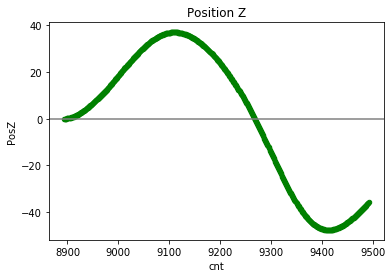

skipping rows: 180


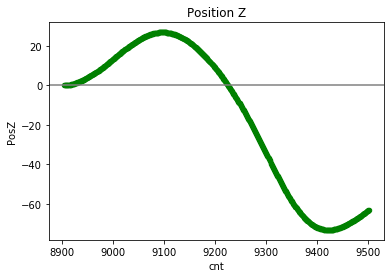

skipping rows: 190


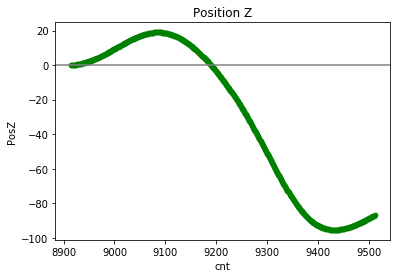

In [10]:
tmpStep = 10 #each plot will start at n*step
tmpLast = 200 #the last row where the plotting loop stops
tmpRowCount = 600 #make sure this spans at least one stroke

#NOTE: in this example, the plot returns to zero somewhere between 150 & 160 - see the plots below

print("Processing a window of", tmpRowCount, "samples, sliding at incriments of", tmpStep)

for n in range(0, tmpLast, tmpStep):
    dfprocessed = ProcessData(df, calibration, skiprows=n, rowcount=tmpRowCount)
    PlotDataProcessed(dfprocessed, False)

skipping rows: 153


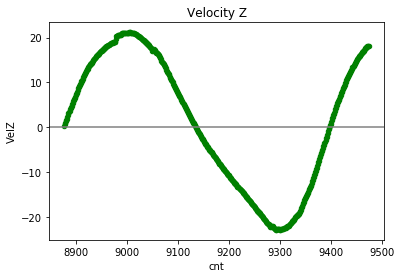

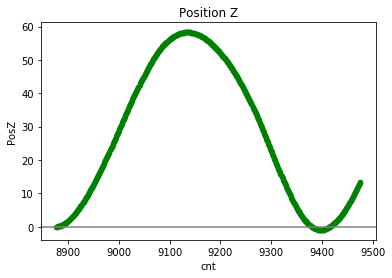

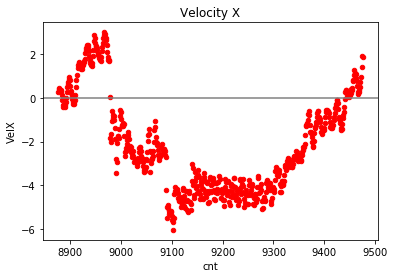

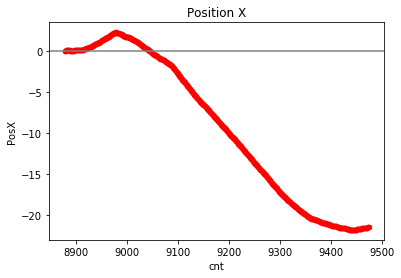

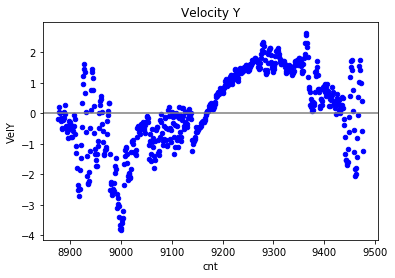

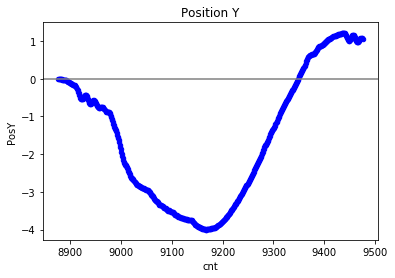

In [11]:
#in progress... calibrate & zero, then double integrate.

skiprows = 153 #found from the plots above
#skiprows += 1 #you could also re-run this same cell and incriment the skiprows each time (just a easy way to find the best fit)
#skiprows -= 1
rowcount = 600

dfprocessed = ProcessData(df, calibration, skiprows=skiprows, rowcount=rowcount)
PlotDataProcessed(dfprocessed, True)

In [12]:
dfprocessed.describe() #get some stats from the processed data. Checkout the max/min values for velocity & position

cnt       totalms    totalmsalt  mspersample    Sch  Press  \
count   600.000000    600.000000    600.000000   600.000000  600.0  600.0   
mean   9175.500000   7536.297000   7547.982821    16.680769    5.0  960.0   
std     173.349358   2887.098892   2891.746947     0.027490    0.0    0.0   
min    8876.000000   2548.184400   2552.000000    16.615385    5.0  960.0   
25%    9025.750000   5042.240700   5049.673077    16.692308    5.0  960.0   
50%    9175.500000   7536.297000   7548.346154    16.692308    5.0  960.0   
75%    9325.250000  10030.353300  10046.019231    16.692308    5.0  960.0   
max    9475.000000  12524.409600  12543.769231    16.692308    5.0  960.0   

               Temp         Volt          AccX         AccY  ...  \
count    600.000000   600.000000    600.000000    600.00000  ...   
mean   16382.396667  8238.214467  17915.278333  17945.41500  ...   
std        2.658528     2.345449    426.297349    404.06143  ...   
min    16376.000000  8232.640000  14299.000000  14440.00000  ...   
25%    16381.000000  8236.230000  17689.000000  17762.75000  ...   
50%    16384.000000  8238.790000  17920.000000  17961.00000  ...   
75%    16384.000000  8240.330000  18159.250000  18139.00000  ...   
max    16387.000000  8240.840000  19578.000000  19517.00000  ...   

       AccelZeroedGZ        VelX        VelY        VelZ   PosDeltaX  \
count     600.000000  599.000000  599.000000  599.000000  599.000000   
mean        0.004774   -2.145035    0.106284    1.327437   -0.035781   
std         0.034066    2.208837    1.287915   14.679246    0.036845   
min        -0.077288   -6.025464   -3.818211  -22.860598   -0.100579   
25%        -0.023509   -4.100820   -0.669430  -12.537490   -0.068452   
50%         0.000760   -2.635709    0.133797    3.620421   -0.043996   
75%         0.032774   -0.593201    1.319799   15.428131   -0.009902   
max         0.208466    2.988556    2.646361   21.183899    0.049886   

        PosDeltaY   PosDeltaZ        PosX        PosY        PosZ  
count  599.000000  599.000000  599.000000  599.000000  599.000000  
mean     0.001777    0.022124   -9.221236   -1.563108   27.440421  
std      0.021474    0.244863    8.870690    1.764649   21.328939  
min     -0.063441   -0.381596  -21.795410   -3.998565   -0.963998  
25%     -0.011174   -0.209280  -18.755434   -3.324116    6.114866  
50%      0.002223    0.060433   -8.359281   -1.511542   25.988873  
75%      0.022030    0.257531    0.035877   -0.080506   49.208709  
max      0.044174    0.352016    2.235486    1.224724   58.282363  

[8 rows x 29 columns]

In [13]:
df.describe() #get some stats from the original unprocessed data

cnt       totalms    totalmsalt  mspersample     Sch   Press  \
count   5000.000000   5000.000000   5000.000000  5000.000000  5000.0  5000.0   
mean   11222.500000  41628.672600  41694.881415    16.654800     5.0   960.0   
std     1443.520003  24041.536951  24079.874801     0.667328     0.0     0.0   
min     8723.000000      0.000000      0.000000     0.000000     5.0   960.0   
25%     9972.750000  20814.336300  20847.288462    16.692308     5.0   960.0   
50%    11222.500000  41628.672600  41695.153846    16.692308     5.0   960.0   
75%    12472.250000  62443.008900  62542.711538    16.692308     5.0   960.0   
max    13722.000000  83257.345200  83257.384615    16.692308     5.0   960.0   

               Temp         Volt          AccX          AccY          AccZ  \
count   5000.000000  5000.000000   5000.000000   5000.000000   5000.000000   
mean   16356.087600  8238.243342  17911.819400  17948.416400  24401.806000   
std       17.624382     2.361360    414.465462    355.175987    238.347685   
min    16328.000000  8232.640000  13894.000000  14283.000000  22480.000000   
25%    16342.000000  8236.230000  17691.000000  17796.750000  24220.000000   
50%    16353.000000  8238.790000  17916.000000  17965.000000  24367.500000   
75%    16369.000000  8240.330000  18148.000000  18113.000000  24566.250000   
max    16392.000000  8240.840000  20994.000000  19996.000000  25963.000000   

              Str1          Str2         Str3  
count  5000.000000   5000.000000  5000.000000  
mean   6730.072800  12957.438000  8788.137400  
std       6.208608      8.019116    20.023654  
min    6710.000000  12936.000000  8756.000000  
25%    6726.000000  12952.000000  8774.000000  
50%    6730.000000  12957.000000  8780.000000  
75%    6734.000000  12962.000000  8797.000000  
max    6753.000000  12988.000000  8843.000000

## ------------------------------ DONE -----------------------------------------------

Everything below here is just experimentation (well, I suppose the whole thing is... this is just leftover code for now)

Now we can plot the data. matplotlib is a bit more interactive when run locally, but this should be good enough for now.
Just plot the individual components to get an overview.

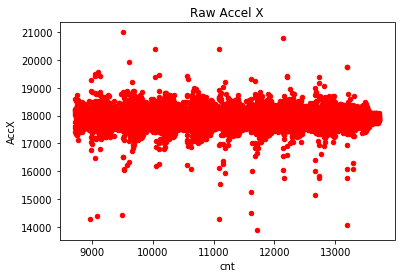

In [14]:
df.plot(kind="scatter", x="cnt", y="AccX", title="Raw Accel X", color="red")
plt.show()

Which channel is this?

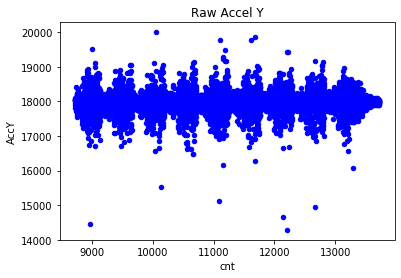

In [15]:
df.plot(kind="scatter", x="cnt", y="AccY", title="Raw Accel Y", color="blue")
plt.show()

I think this is Z

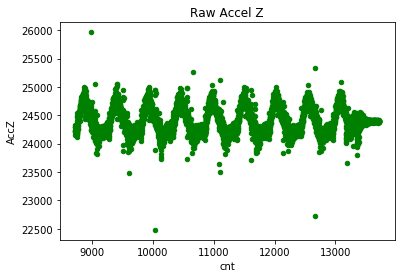

In [16]:
df.plot(kind="scatter", x="cnt", y="AccZ", title="Raw Accel Z", color="green")
plt.show()

TODO: Fix this stuff below

Lets get the gravity vector now. This should also be the direction of tool travel. Ideally, the samples that are not part of normal motion should have been eliminated above, and we should have enough samples to wash out partial strokes at the beginning/end.

In [17]:
gravityv = vmath.Vector3(df["AccX"].mean(), df["AccY"].mean(), df["AccZ"].mean())
print("Gravity vector:", gravityv)

#not sure if these next few lines are needed....

#I suck at python, but this should be an array of x,y,z vectors
arrxyz = np.reshape((np.array(df["AccX"]), np.array(df["AccY"]), np.array(df["AccZ"])), (3, -1)).transpose()


#load them into a Vector3Array to operate on
v_array = vmath.Vector3Array(arrxyz)

Gravity vector: [17911.8194 17948.4164 24401.806 ]


Give a 3D view of that gravity vector... should roughly indicate the orientation of the tool.

In [18]:
pg = pv.Plotter()
pg.set_background("gray")
veczero = np.array([0., 0., 0.])

#TODO: probably want to orient these so direction of travel is up/down on this plot
vecgrav = np.array([calibration["AccelMeanX"]*32000, calibration["AccelMeanY"]*32000, calibration["AccelMeanZ"]*32000])
gravline = np.stack((veczero, vecgrav))
_ = pg.add_lines(gravline, color="red")

print(vecgrav)

#because I cant figure out how to plot the proper grid in pyvista. This is a bit hacky.
vertline = np.stack((veczero, np.array([0., 32000., 0.])))
_ = pg.add_lines(vertline, color="blue")


horiline = np.stack((veczero, np.array([32000., 0., 0.])))
_ = pg.add_lines(horiline, color="blue")

horiline = np.stack((veczero, np.array([-32000., 0., 0.])))
_ = pg.add_lines(horiline, color="blue")

horiline = np.stack((veczero, np.array([0., 0., 32000.])))
_ = pg.add_lines(horiline, color="green")

horiline = np.stack((veczero, np.array([0., 0., -32000.])))
_ = pg.add_lines(horiline, color="green")



_ = pg.add_axes(interactive=True, color="blue") #notebook doesnt render helper
_ = pg.show_bounds(grid="front", location="outer", all_edges=True, color="red")
pg.show_grid() #not working?

[ 2725.33592185  3133.19301478 32066.47011067]


In [19]:
pg.plot()

VTK(vtkXOpenGLRenderWindow, height=400, sizing_mode='stretch_width')

## TODO: should apply calibration to the raw sample data

Just plot all acceleration samples. Not too helpful at this point.

In [20]:
p = pv.Plotter()
p.set_background("gray")

verts = np.column_stack((df["AccX"], df["AccY"], df["AccZ"]))
_ = p.add_points(verts, color="red")
_ = p.add_axes()

In [21]:
p.show()

VTK(vtkXOpenGLRenderWindow, height=400, sizing_mode='stretch_width')

In [22]:
pc = pv.PolyData(verts)
pc.plot(point_size=1, show_grid=True, color="red")

VTK(vtkXOpenGLRenderWindow, height=400, sizing_mode='stretch_width')

In [23]:
print("test")

test
